In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
from transformers import AutoTokenizer, GPT2Model # Changed from AutoModel to GPT2Model
import torch
import numpy as np
import os
from tqdm.auto import tqdm
import pandas as pd
from datasets import load_dataset
EMB_PATH = '/content/drive/MyDrive/biasbios_gpt2_embeddings.npy'
# ====================================================================

if os.path.exists(EMB_PATH):
 embeddings = np.load(EMB_PATH)
 print('Loaded GPT-2 embeddings from PERSISTENT cache:', EMB_PATH)

Loaded GPT-2 embeddings from PERSISTENT cache: /content/drive/MyDrive/biasbios_gpt2_embeddings.npy


In [2]:
# Assuming all necessary packages (transformers, datasets, aif360, fairlearn, scikit-learn, numpy, pandas) are installed.

from google.colab import drive
import os
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, GPT2Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm.auto import tqdm
from datasets import load_dataset # Necessary for loading df

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. MOUNT DRIVE AND SET PATH ---
# You must execute this section when starting a new session
if not os.path.exists('/content/drive/MyDrive'):
    try:
        drive.mount('/content/drive')
    except Exception as e:
        print(f"Warning: Could not mount Google Drive. Embeddings will not be saved permanently. Error: {e}")
        # Fallback to temporary path if Drive cannot be mounted
        EMB_PATH = '/tmp/biasbios_gpt2_embeddings.npy'

EMB_PATH = '/content/drive/MyDrive/biasbios_gpt2_embeddings.npy' # Persistent path


# --- 2. DATA LOADING and PREPROCESSING (Defines 'df') ---

try:
    print('Loading Bias in Bios dataset (LabHC/bias_in_bios)...')
    # Load the same small sample size (5000) for speed
    ds_train = load_dataset("LabHC/bias_in_bios", split='train').select(range(5000))
    df_raw = pd.DataFrame(ds_train)

    # Preprocessing logic derived from the notebook history
    df = pd.DataFrame()
    df['text'] = df_raw['hard_text'].astype(str)
    df['gender_raw'] = df_raw['gender']

    # Infer protected attribute 'A' (1=Male, 0=Female) and 'label' (Y)
    male_code = 1 # Assuming 1 is the male code based on prior analysis of this dataset
    df['protected'] = (df['gender_raw'] == male_code).astype(int)
    most_common_prof = df_raw['profession'].value_counts().idxmax()
    df['label'] = (df_raw['profession'] == most_common_prof).astype(int)

    # Filter to ensure clean binary sensitive attributes
    df = df[df['gender_raw'].isin([0, 1])].reset_index(drop=True)

    print(f'✅ Data frame df created with {len(df)} rows.')

except Exception as e:
    print(f"FATAL: Error during data loading. Cannot proceed. Error: {e}")
    exit()


# --- 3. MODEL AND TOKENIZER SETUP (Defines 'model' and 'tokenizer') ---

TOKENIZER_NAME = 'gpt2'
MODEL_NAME = 'gpt2'

print("Loading GPT-2 model and tokenizer...")
try:
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
    model = GPT2Model.from_pretrained(MODEL_NAME)
    model.eval()

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model.to(device)
    print("✅ GPT-2 Model loaded successfully.")
except Exception as e:
    print(f"FATAL: Error loading GPT-2. Check environment/internet connection. Error: {e}")
    exit()


# --- 4. CACHING LOGIC (Guarantees 'embeddings' are defined) ---

embeddings = None # Initialize to avoid NameError

if os.path.exists(EMB_PATH):
    embeddings = np.load(EMB_PATH)
    print('Loaded GPT-2 embeddings from PERSISTENT cache:', EMB_PATH)
else:
    print('Cache file not found. Starting embedding extraction (This will be slow on the first run)...')

    texts = df['text'].astype(str).tolist()
    batch_size = 16 if device.type == 'cuda' else 8
    all_embs = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting GPT-2 Embeddings"):
        batch_texts = texts[i:i+batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=128
        ).to(device)

        with torch.no_grad():
            out = model(input_ids=enc['input_ids'], attention_mask=enc['attention_mask'])
            # Use the hidden state of the first token [0, :] as the sentence representation
            pooled = out.last_hidden_state[:, 0, :].cpu().numpy()
            all_embs.append(pooled)

    embeddings = np.vstack(all_embs)
    np.save(EMB_PATH, embeddings)
    print(f'✅ Saved GPT-2 embeddings to PERSISTENT file: {EMB_PATH}')


# --- 5. BASELINE CLASSIFICATION ---

X = embeddings
y = df['label'].values
A = df['protected'].values  # 1 = privileged (male), 0 = unprivileged (female)

print('\nEmbedding extraction/loading complete. Running baseline classifier.')
print('X shape:', X.shape)

# stratify by label for balanced splits
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.30, random_state=42, stratify=y
)

print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

# Baseline Logistic Regression Model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:, 1]

print('Baseline accuracy:', accuracy_score(y_test, y_pred))
try:
    print('Baseline ROC AUC:', roc_auc_score(y_test, probs))
except Exception as e:
    print('ROC AUC error (maybe single class in test):', e)

Using device: cuda
Loading Bias in Bios dataset (LabHC/bias_in_bios)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Data frame df created with 5000 rows.
Loading GPT-2 model and tokenizer...
✅ GPT-2 Model loaded successfully.
Loaded GPT-2 embeddings from PERSISTENT cache: /content/drive/MyDrive/biasbios_gpt2_embeddings.npy

Embedding extraction/loading complete. Running baseline classifier.
X shape: (5000, 768)
Train size: 3500 Test size: 1500
Baseline accuracy: 0.6933333333333334
Baseline ROC AUC: 0.6501867395980372


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [3]:
import numpy as np

def compute_group_rates(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    rate_priv = y_pred[priv_mask].mean() if priv_mask.sum() > 0 else np.nan
    rate_unpriv = y_pred[unpriv_mask].mean() if unpriv_mask.sum() > 0 else np.nan
    return rate_priv, rate_unpriv

def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    return r_unpriv - r_priv

def disparate_impact(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    if r_priv == 0:
        return np.nan
    return r_unpriv / r_priv

def equal_opportunity_difference(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    def tpr(y_t, y_p, mask):
        m = mask & (y_t == 1)
        return y_p[m].mean() if m.sum() > 0 else np.nan
    return tpr(y_true, y_pred, unpriv_mask) - tpr(y_true, y_pred, priv_mask)

# Evaluate baseline
spd = statistical_parity_difference(y_test, y_pred, A_test)
di = disparate_impact(y_test, y_pred, A_test)
eod = equal_opportunity_difference(y_test, y_pred, A_test)

print('Baseline SPD:', spd)
print('Baseline DI:', di)
print('Baseline EOD:', eod)

Baseline SPD: -0.12851172322537963
Baseline DI: 0.07877385772122615
Baseline EOD: -0.22184622648933658


In [4]:
!pip install fairlearn

In [6]:
# Assuming X_train, y_train, A_train, X_test, y_test, A_test are defined.

# --- 1. Import Dependencies and Define Utility Functions (Necessary) ---
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
try:
    from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds
    from fairlearn.metrics import MetricFrame
    FAIRLEARN_AVAILABLE = True
except ImportError:
    FAIRLEARN_AVAILABLE = False
    print("FATAL: Fairlearn package not installed/available. Please run '!pip install fairlearn'")

# Re-define metric helpers to make this block self-contained
def compute_group_rates(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    rate_priv = y_pred[priv_mask].mean() if priv_mask.sum() > 0 else np.nan
    rate_unpriv = y_pred[unpriv_mask].mean() if unpriv_mask.sum() > 0 else np.nan
    return rate_priv, rate_unpriv

def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    return r_unpriv - r_priv

def disparate_impact(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    if r_priv == 0:
        return np.nan
    return r_unpriv / r_priv

def equal_opportunity_difference(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    def tpr(y_t, y_p, mask):
        m = mask & (y_t == 1)
        return y_p[m].mean() if m.sum() > 0 else np.nan
    return tpr(y_true, y_pred, unpriv_mask) - tpr(y_true, y_pred, priv_mask)


# --- 2. Run Fairlearn Mitigation (FIXED CONVERGENCE) ---
if FAIRLEARN_AVAILABLE:
    print('\n--- Running Fairlearn In-Processing Mitigation (on GPT-2 Embeddings) ---')

    # FIX: Use 'saga' solver and increased max_iter to prevent ConvergenceWarning
    base_est = LogisticRegression(solver='saga', max_iter=5000, random_state=42, penalty='l2')

    # Exponentiated Gradient (Equalized Odds)
    print('\nRunning ExponentiatedGradient (Equalized Odds)...')
    eg = ExponentiatedGradient(base_est, constraints=EqualizedOdds(), eps=0.01)

    # NOTE: The fit process itself will now be slower due to the increased max_iter=5000
    eg.fit(X_train, y_train, sensitive_features=A_train)
    y_pred_eg = eg.predict(X_test)

    print('EG Accuracy:', accuracy_score(y_test, y_pred_eg))
    print('EG SPD:', statistical_parity_difference(y_test, y_pred_eg, A_test))
    print('EG DI:', disparate_impact(y_test, y_pred_eg, A_test))
    print('EG EOD:', equal_opportunity_difference(y_test, y_pred_eg, A_test))

    # Grid Search (Demographic Parity)
    print('\nRunning GridSearch (Demographic Parity)...')
    gs = GridSearch(base_est, constraints=DemographicParity(), grid_size=5)
    gs.fit(X_train, y_train, sensitive_features=A_train)

    # GridSearch runs the base estimator many times, expect it to be slow!
    y_pred_gs = gs.predict(X_test)

    print('GS Accuracy:', accuracy_score(y_test, y_pred_gs))
    print('GS SPD:', statistical_parity_difference(y_test, y_pred_gs, A_test))
    print('GS DI:', disparate_impact(y_test, y_pred_gs, A_test))
    print('GS EOD:', equal_opportunity_difference(y_test, y_pred_gs, A_test))
else:
    print('Fairlearn not available — skipping ExponentiatedGradient & GridSearch')


--- Running Fairlearn In-Processing Mitigation (on GPT-2 Embeddings) ---

Running ExponentiatedGradient (Equalized Odds)...
EG Accuracy: 0.6933333333333334
EG SPD: 0.028981297703764675
EG DI: 1.1973626373626374
EG EOD: 0.027386479892972382

Running GridSearch (Demographic Parity)...
GS Accuracy: 0.6933333333333334
GS SPD: -0.12851172322537963
GS DI: 0.07877385772122615
GS EOD: -0.22184622648933658


In [8]:
!pip install aif360==0.6.0
!pip install tensorflow==2.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.8/229.8 kB 16.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0


In [10]:
# Assuming X_train, y_train, A_train, X_test, y_test, A_test are defined.
import numpy as np
import pandas as pd

# Re-define metric helpers (to ensure the print statements work)
def compute_group_rates(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    rate_priv = y_pred[priv_mask].mean() if priv_mask.sum() > 0 else np.nan
    rate_unpriv = y_pred[unpriv_mask].mean() if unpriv_mask.sum() > 0 else np.nan
    return rate_priv, rate_unpriv

def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    return r_unpriv - r_priv

def disparate_impact(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    if r_priv == 0:
        return np.nan
    return r_unpriv / r_priv

def equal_opportunity_difference(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    def tpr(y_t, y_p, mask):
        m = mask & (y_t == 1)
        return y_p[m].mean() if m.sum() > 0 else np.nan
    return tpr(y_true, y_pred, unpriv_mask) - tpr(y_true, y_pred, priv_mask)

# --- AIF360 Setup and Execution ---
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.inprocessing import PrejudiceRemover, AdversarialDebiasing
    import tensorflow as tf
    # Silence V2 warnings for AIF360 compatibility
    tf.compat.v1.disable_eager_execution()
    AIF360_AVAILABLE = True
except ImportError as e:
    AIF360_AVAILABLE = False
    print(f'AIF360 or TensorFlow failed to import: {e}. Skipping AIF360 methods.')


if AIF360_AVAILABLE:

    def make_aif360_dataset(X_arr, y_arr, A_arr):
        """Creates an AIF360 StandardDataset object from numpy arrays."""
        df_temp = pd.DataFrame(X_arr)
        df_temp['label'] = y_arr
        df_temp['protected'] = A_arr
        # Feature names are required by AIF360
        feat_names = [f'f{i}' for i in range(X_arr.shape[1])] + ['label', 'protected']
        df_temp.columns = feat_names
        return StandardDataset(df_temp, label_name='label', favorable_classes=[1],
                               protected_attribute_names=['protected'], privileged_classes=[[1]])

    aif_train = make_aif360_dataset(X_train, y_train, A_train)
    aif_test = make_aif360_dataset(X_test, y_test, A_test)

    # ------------------------------------
    # 1. PrejudiceRemover
    # ------------------------------------
    print('\n--- Running PrejudiceRemover (In-Processing) ---')
    try:
        pr = PrejudiceRemover(eta=25.0)
        pr.fit(aif_train)
        ypred_pr = pr.predict(aif_test).labels.ravel()
        print('PR SPD:', statistical_parity_difference(y_test, ypred_pr, A_test))
        print('PR DI:', disparate_impact(y_test, ypred_pr, A_test))
        print('PR EOD:', equal_opportunity_difference(y_test, ypred_pr, A_test))
    except Exception as e:
        print(f'PrejudiceRemover failed: {e}.')

    # ------------------------------------
    # 2. AdversarialDebiasing
    # ------------------------------------
    print('\n--- Running AdversarialDebiasing (In-Processing, TensorFlow) ---')
    try:
        # Reset graph for a clean run, crucial for TF 1.x environments
        tf.compat.v1.reset_default_graph()
        sess = tf.compat.v1.Session()
        # Set parameters for a faster run (fewer epochs, larger batch)
        adv = AdversarialDebiasing(
            privileged_groups=[{'protected':1}],
            unprivileged_groups=[{'protected':0}],
            scope_name='adv_gpt2', debias=True, sess=sess,
            num_epochs=50, # Reduced epochs for speed
            batch_size=128 # Increased batch size for GPU efficiency
        )
        print("Training AdversarialDebiasing...")
        adv.fit(aif_train)
        ypred_adv = adv.predict(aif_test).labels.ravel()
        print('Adv SPD:', statistical_parity_difference(y_test, ypred_adv, A_test))
        print('Adv DI:', disparate_impact(y_test, ypred_adv, A_test))
        print('Adv EOD:', equal_opportunity_difference(y_test, ypred_adv, A_test))
        sess.close()
    except Exception as e:
        print(f'AdversarialDebiasing failed: {e}.')
else:
    print('AIF360 not available — skipping PrejudiceRemover & AdversarialDebiasing')


--- Running PrejudiceRemover (In-Processing) ---


/usr/local/lib/python3.12/dist-packages/aif360/algorithms/inprocessing/prejudice_remover.py:208: UserWarning: loadtxt: input contained no data: "/tmp/tmppglkk_6i"
  m = np.loadtxt(output_name)


PrejudiceRemover failed: too many indices for array: array is 1-dimensional, but 2 were indexed.

--- Running AdversarialDebiasing (In-Processing, TensorFlow) ---
Training AdversarialDebiasing...
epoch 0; iter: 0; batch classifier loss: 3.614754; batch adversarial loss: 1.092948
epoch 1; iter: 0; batch classifier loss: 0.735042; batch adversarial loss: 0.820581
epoch 2; iter: 0; batch classifier loss: 0.875120; batch adversarial loss: 0.851140
epoch 3; iter: 0; batch classifier loss: 0.810910; batch adversarial loss: 0.958656
epoch 4; iter: 0; batch classifier loss: 0.903529; batch adversarial loss: 0.979928
epoch 5; iter: 0; batch classifier loss: 0.885101; batch adversarial loss: 0.945862
epoch 6; iter: 0; batch classifier loss: 0.856829; batch adversarial loss: 0.956056
epoch 7; iter: 0; batch classifier loss: 0.791584; batch adversarial loss: 0.942352
epoch 8; iter: 0; batch classifier loss: 0.848455; batch adversarial loss: 0.899117
epoch 9; iter: 0; batch classifier loss: 0.74320

In [12]:
# Assuming ypred_adv is defined from the previous successful run
accuracy_adv = np.mean(ypred_adv == y_test)
print(f"Adv. Debiasing Accuracy: {accuracy_adv}")

Adv. Debiasing Accuracy: 0.6953333333333334


In [14]:
# Assuming X_train, y_train, A_train, X_test, y_test, A_test are defined.
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# --- Import AIF360 dependencies (ensures availability) ---
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.inprocessing import PrejudiceRemover, AdversarialDebiasing
    import tensorflow as tf
    # Silence V2 warnings for AIF360 compatibility
    tf.compat.v1.disable_eager_execution()
    AIF360_AVAILABLE = True
except ImportError as e:
    AIF360_AVAILABLE = False
    print(f'AIF360 or TensorFlow failed to import: {e}. Cannot run PrejudiceRemover.')

# --- Metric Helpers (Needed for printouts) ---
def compute_group_rates(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    rate_priv = y_pred[priv_mask].mean() if priv_mask.sum() > 0 else np.nan
    rate_unpriv = y_pred[unpriv_mask].mean() if unpriv_mask.sum() > 0 else np.nan
    return rate_priv, rate_unpriv

def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    return r_unpriv - r_priv

def disparate_impact(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    if r_priv == 0: return np.nan
    return r_unpriv / r_priv

def equal_opportunity_difference(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    def tpr(y_t, y_p, mask):
        m = mask & (y_t == 1)
        return y_p[m].mean() if m.sum() > 0 else np.nan
    return tpr(y_true, y_pred, unpriv_mask) - tpr(y_true, y_pred, priv_mask)

# --- AIF360 Setup and Execution with Scaling (NO PCA) ---

if AIF360_AVAILABLE:
    print('\n--- Preprocessing: Standard Scaling of GPT-2 Dimensions (NO PCA) ---')

    # Step 1: Scale features (Crucial for stability)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # X_train_scaled and X_test_scaled now have 768 dimensions

    # --- AIF360 Dataset Creation (Using Scaled, Full Features) ---
    def make_aif360_dataset(X_arr, y_arr, A_arr):
        df_temp = pd.DataFrame(X_arr)
        df_temp['label'] = y_arr
        df_temp['protected'] = A_arr
        # Name features uniquely
        feat_names = [f'f{i}' for i in range(X_arr.shape[1])] + ['label', 'protected']
        df_temp.columns = feat_names
        return StandardDataset(df_temp, label_name='label', favorable_classes=[1],
                               protected_attribute_names=['protected'], privileged_classes=[[1]])

    aif_train = make_aif360_dataset(X_train_scaled, y_train, A_train)
    aif_test = make_aif360_dataset(X_test_scaled, y_test, A_test)


    # ------------------------------------
    # 1. PrejudiceRemover (Full Features)
    # ------------------------------------
    print('\n--- Running PrejudiceRemover (In-Processing on FULL 768 Features) ---')
    try:
        pr = PrejudiceRemover(eta=25.0)
        pr.fit(aif_train) # This is the step that may crash due to high dimensionality
        ypred_pr = pr.predict(aif_test).labels.ravel()

        # Evaluate PR results
        acc_pr = accuracy_score(y_test, ypred_pr)
        print('PR Accuracy:', acc_pr)
        print('PR SPD:', statistical_parity_difference(y_test, ypred_pr, A_test))
        print('PR DI:', disparate_impact(y_test, ypred_pr, A_test))
        print('PR EOD:', equal_opportunity_difference(y_test, ypred_pr, A_test))

    except Exception as e:
        print(f'PrejudiceRemover failed on full features: {e}. (This confirms the dimension issue).')

    # ------------------------------------
    # 2. AdversarialDebiasing (Full Features)
    # ------------------------------------
    print('\n--- Running AdversarialDebiasing (In-Processing on FULL 768 Features) ---')
    try:
        tf.compat.v1.reset_default_graph()
        sess = tf.compat.v1.Session()
        adv = AdversarialDebiasing(
            privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}],
            scope_name='adv_full_gpt2', debias=True, sess=sess,
            num_epochs=50,
            batch_size=128
        )
        adv.fit(aif_train)
        ypred_adv_full = adv.predict(aif_test).labels.ravel()

        # Evaluate Adv results
        acc_adv_full = accuracy_score(y_test, ypred_adv_full)
        print('Adv (Full) Accuracy:', acc_adv_full)
        print('Adv (Full) SPD:', statistical_parity_difference(y_test, ypred_adv_full, A_test))
        print('Adv (Full) DI:', disparate_impact(y_test, ypred_adv_full, A_test))
        print('Adv (Full) EOD:', equal_opportunity_difference(y_test, ypred_adv_full, A_test))
        sess.close()
    except Exception as e:
        print(f'AdversarialDebiasing (Full) failed: {e}.')
else:
    print('AIF360 not available — cannot run PrejudiceRemover.')


--- Preprocessing: Standard Scaling of GPT-2 Dimensions (NO PCA) ---

--- Running PrejudiceRemover (In-Processing on FULL 768 Features) ---


/usr/local/lib/python3.12/dist-packages/aif360/algorithms/inprocessing/prejudice_remover.py:208: UserWarning: loadtxt: input contained no data: "/tmp/tmp98_bgy12"
  m = np.loadtxt(output_name)


PrejudiceRemover failed on full features: too many indices for array: array is 1-dimensional, but 2 were indexed. (This confirms the dimension issue).

--- Running AdversarialDebiasing (In-Processing on FULL 768 Features) ---
epoch 0; iter: 0; batch classifier loss: 0.668129; batch adversarial loss: 0.692786
epoch 1; iter: 0; batch classifier loss: 0.698218; batch adversarial loss: 0.690636
epoch 2; iter: 0; batch classifier loss: 0.501605; batch adversarial loss: 0.692691
epoch 3; iter: 0; batch classifier loss: 0.562619; batch adversarial loss: 0.693257
epoch 4; iter: 0; batch classifier loss: 0.512425; batch adversarial loss: 0.684409
epoch 5; iter: 0; batch classifier loss: 0.572414; batch adversarial loss: 0.679900
epoch 6; iter: 0; batch classifier loss: 0.684025; batch adversarial loss: 0.682567
epoch 7; iter: 0; batch classifier loss: 0.513050; batch adversarial loss: 0.694340
epoch 8; iter: 0; batch classifier loss: 0.581549; batch adversarial loss: 0.677405
epoch 9; iter: 0; 

In [15]:
# Assuming X_test, y_test, A_test, y_pred (baseline predictions), and clf (baseline model) are defined.
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# --- Import AIF360 dependencies ---
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification, CalibratedEqOddsPostprocessing
    AIF360_AVAILABLE = True
except ImportError as e:
    AIF360_AVAILABLE = False
    print(f'AIF360 failed to import: {e}. Skipping post-processing methods.')

# --- Metric Helpers (Needed for final aggregation) ---
def compute_group_rates(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    rate_priv = y_pred[priv_mask].mean() if priv_mask.sum() > 0 else np.nan
    rate_unpriv = y_pred[unpriv_mask].mean() if unpriv_mask.sum() > 0 else np.nan
    return rate_priv, rate_unpriv

def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    return r_unpriv - r_priv

def disparate_impact(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    if r_priv == 0: return np.nan
    return r_unpriv / r_priv

def equal_opportunity_difference(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    def tpr(y_t, y_p, mask):
        m = mask & (y_t == 1)
        return y_p[m].mean() if m.sum() > 0 else np.nan
    return tpr(y_true, y_pred, unpriv_mask) - tpr(y_true, y_pred, priv_mask)

# --- Post-Processing Execution ---

if AIF360_AVAILABLE:
    print('\n--- Running AIF360 Post-processing Methods (on Baseline Classifier) ---')

    # 1. Prepare AIF360 Datasets
    test_df = pd.DataFrame(X_test)
    test_df['label'] = y_test
    test_df['protected'] = A_test

    # We need the probability scores (probs) for the post-processing algorithms
    test_df['score'] = probs

    protected_attribute_names = ['protected']
    privileged_classes = [[1]]

    # The "true" dataset (labels for metrics)
    test_dataset = StandardDataset(test_df, label_name='label', favorable_classes=[1],
                                   protected_attribute_names=protected_attribute_names, privileged_classes=privileged_classes)

    # The "predicted" dataset (predictions/scores from the baseline model)
    pred_dataset = StandardDataset(test_df, label_name='score', favorable_classes=[1],
                                   protected_attribute_names=protected_attribute_names, privileged_classes=privileged_classes)

    all_post_results = []

    # --- 1. Equalized Odds Postprocessing (EOP) ---
    print('1. Equalized Odds Postprocessing (EOP)...')
    eq = EqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}])
    eq = eq.fit(test_dataset, pred_dataset)
    y_pred_eq = eq.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Eq. Odds Postproc',
        'Accuracy': accuracy_score(y_test, y_pred_eq),
        'SPD': statistical_parity_difference(y_test, y_pred_eq, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_eq, A_test),
        'DI': disparate_impact(y_test, y_pred_eq, A_test)
    })

    # --- 2. Reject Option Classification (ROC) ---
    print('2. Reject Option Classification (ROC)...')
    roc = RejectOptionClassification(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}],
                                     low_class_thresh=0.01, high_class_thresh=0.99, num_class_thresh=100, num_ROC_margin=50)
    roc = roc.fit(test_dataset, pred_dataset)
    y_pred_roc = roc.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Reject Option Class.',
        'Accuracy': accuracy_score(y_test, y_pred_roc),
        'SPD': statistical_parity_difference(y_test, y_pred_roc, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_roc, A_test),
        'DI': disparate_impact(y_test, y_pred_roc, A_test)
    })

    # --- 3. Calibrated Equalized Odds (CEO) ---
    print('3. Calibrated Equalized Odds (CEO)...')
    ceo = CalibratedEqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}], cost_constraint='fnr')
    ceo = ceo.fit(test_dataset, pred_dataset)
    y_pred_ceo = ceo.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Calibrated Eq. Odds',
        'Accuracy': accuracy_score(y_test, y_pred_ceo),
        'SPD': statistical_parity_difference(y_test, y_pred_ceo, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_ceo, A_test),
        'DI': disparate_impact(y_test, y_pred_ceo, A_test)
    })

    # --- Final Output ---
    post_df = pd.DataFrame(all_post_results)
    print("\n\n" + "="*80)
    print("📊 POST-PROCESSING MITIGATION RESULTS (GPT-2 Embeddings) 📊")
    print("================================================================================")
    print(post_df[['Method', 'Accuracy', 'SPD', 'EOD', 'DI']].set_index('Method').round(4))
    print("================================================================================")

else:
    print('AIF360 not available — skipping post-processing methods.')


--- Running AIF360 Post-processing Methods (on Baseline Classifier) ---
1. Equalized Odds Postprocessing (EOP)...


ValueError: The two datasets are expected to differ only in 'labels' or 'scores'.

In [16]:
# Assuming X_test, y_test, A_test, y_pred (baseline predictions), and probs (baseline probabilities) are defined.
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# --- Import AIF360 dependencies ---
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification, CalibratedEqOddsPostprocessing
    AIF360_AVAILABLE = True
except ImportError as e:
    AIF360_AVAILABLE = False
    print(f'AIF360 failed to import: {e}. Skipping post-processing methods.')

# --- Metric Helpers (Re-defined for self-containment) ---
def compute_group_rates(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    rate_priv = y_pred[priv_mask].mean() if priv_mask.sum() > 0 else np.nan
    rate_unpriv = y_pred[unpriv_mask].mean() if unpriv_mask.sum() > 0 else np.nan
    return rate_priv, rate_unpriv

def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    return r_unpriv - r_priv

def disparate_impact(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    if r_priv == 0: return np.nan
    return r_unpriv / r_priv

def equal_opportunity_difference(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    def tpr(y_t, y_p, mask):
        m = mask & (y_t == 1)
        return y_p[m].mean() if m.sum() > 0 else np.nan
    return tpr(y_true, y_pred, unpriv_mask) - tpr(y_true, y_pred, priv_mask)

# --- Post-Processing Execution ---

if AIF360_AVAILABLE:
    print('\n--- Running AIF360 Post-processing Methods (on Baseline Classifier) ---')

    # 1. Prepare AIF360 Datasets

    # Create a base DataFrame containing features, true labels, and protected attributes
    feat_names = [f'f{i}' for i in range(X_test.shape[1])]
    base_df = pd.DataFrame(X_test, columns=feat_names)
    base_df['protected'] = A_test
    base_df['true_label'] = y_test

    # Add model scores (probabilities)
    base_df['score'] = probs

    protected_attribute_names = ['protected']
    privileged_classes = [[1]]

    # Create the 'true' dataset for metric calculations
    # This dataset must contain the true labels ('true_label')
    test_dataset = StandardDataset(base_df, label_name='true_label', favorable_classes=[1],
                                   protected_attribute_names=protected_attribute_names, privileged_classes=privileged_classes)

    # Create the 'predicted' dataset for fitting the post-processing algorithm
    # This dataset must contain the true labels AND the model scores/predictions.
    # We must explicitly tell AIF360 which column contains the scores.
    pred_dataset = test_dataset.copy(deepcopy=True)
    pred_dataset.scores = probs.reshape(-1, 1) # Must be a 2D array (n_samples, 1)

    # Explicitly set the names to avoid the comparison error
    # NOTE: The fit method uses test_dataset (true labels) and pred_dataset (predicted scores)

    all_post_results = []

    # --- 1. Equalized Odds Postprocessing (EOP) ---
    print('1. Equalized Odds Postprocessing (EOP)...')
    eq = EqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}])
    # Fit uses the true labels (test_dataset) and the model scores (pred_dataset)
    eq = eq.fit(test_dataset, pred_dataset)
    # Predict uses the post-processing model on the prediction scores
    y_pred_eq = eq.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Eq. Odds Postproc',
        'Accuracy': accuracy_score(y_test, y_pred_eq),
        'SPD': statistical_parity_difference(y_test, y_pred_eq, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_eq, A_test),
        'DI': disparate_impact(y_test, y_pred_eq, A_test)
    })

    # --- 2. Reject Option Classification (ROC) ---
    print('2. Reject Option Classification (ROC)...')
    roc = RejectOptionClassification(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}],
                                     low_class_thresh=0.01, high_class_thresh=0.99, num_class_thresh=100, num_ROC_margin=50)
    roc = roc.fit(test_dataset, pred_dataset)
    y_pred_roc = roc.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Reject Option Class.',
        'Accuracy': accuracy_score(y_test, y_pred_roc),
        'SPD': statistical_parity_difference(y_test, y_pred_roc, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_roc, A_test),
        'DI': disparate_impact(y_test, y_pred_roc, A_test)
    })

    # --- 3. Calibrated Equalized Odds (CEO) ---
    print('3. Calibrated Equalized Odds (CEO)...')
    ceo = CalibratedEqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}], cost_constraint='fnr')
    ceo = ceo.fit(test_dataset, pred_dataset)
    y_pred_ceo = ceo.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Calibrated Eq. Odds',
        'Accuracy': accuracy_score(y_test, y_pred_ceo),
        'SPD': statistical_parity_difference(y_test, y_pred_ceo, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_ceo, A_test),
        'DI': disparate_impact(y_test, y_pred_ceo, A_test)
    })

    # --- Final Output ---
    post_df = pd.DataFrame(all_post_results)
    print("\n\n" + "="*80)
    print("📊 POST-PROCESSING MITIGATION RESULTS (GPT-2 Embeddings) 📊")
    print("================================================================================")
    print(post_df[['Method', 'Accuracy', 'SPD', 'EOD', 'DI']].set_index('Method').round(4))
    print("================================================================================")

else:
    print('AIF360 not available — skipping post-processing methods.')


--- Running AIF360 Post-processing Methods (on Baseline Classifier) ---
1. Equalized Odds Postprocessing (EOP)...
2. Reject Option Classification (ROC)...
3. Calibrated Equalized Odds (CEO)...


📊 POST-PROCESSING MITIGATION RESULTS (GPT-2 Embeddings) 📊
                      Accuracy     SPD     EOD      DI
Method                                                
Eq. Odds Postproc        1.000  0.0350  0.0000  1.1230
Reject Option Class.     0.508 -0.0052  0.0150  0.9926
Calibrated Eq. Odds      0.694 -0.1270 -0.2218  0.0796


In [17]:
# --- Corrected Post-Processing Code Block ---
# Assuming X_test, y_test, A_test, y_pred, and probs are defined.

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# --- Import AIF360 dependencies ---
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification, CalibratedEqOddsPostprocessing
    AIF360_AVAILABLE = True
except ImportError:
    AIF360_AVAILABLE = False

# --- Metric Helpers (Defining these again for robustness) ---
def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv = y_pred[protected_attr == 1].mean()
    r_unpriv = y_pred[protected_attr == 0].mean()
    return r_unpriv - r_priv
def disparate_impact(y_true, y_pred, protected_attr):
    r_priv = y_pred[protected_attr == 1].mean()
    r_unpriv = y_pred[protected_attr == 0].mean()
    return r_unpriv / r_priv if r_priv != 0 else np.nan
def equal_opportunity_difference(y_true, y_pred, protected_attr):
    tpr_priv = y_pred[(protected_attr == 1) & (y_true == 1)].mean()
    tpr_unpriv = y_pred[(protected_attr == 0) & (y_true == 1)].mean()
    return tpr_unpriv - tpr_priv

# --- Post-Processing Execution ---
if AIF360_AVAILABLE:
    print('\n--- Running AIF360 Post-processing Methods (on Baseline Classifier) ---')

    # 1. Prepare AIF360 Datasets

    # Create a single base DataFrame
    feat_names = [f'f{i}' for i in range(X_test.shape[1])]
    base_df = pd.DataFrame(X_test, columns=feat_names)
    base_df['protected'] = A_test
    base_df['true_label'] = y_test
    base_df['baseline_prediction'] = y_pred # Binary prediction
    base_df['baseline_score'] = probs     # Probability score

    protected_attribute_names = ['protected']
    privileged_classes = [[1]]

    # True Dataset (Contains TRUE labels - y_test)
    test_dataset = StandardDataset(base_df, label_name='true_label', favorable_classes=[1],
                                   protected_attribute_names=protected_attribute_names, privileged_classes=privileged_classes,
                                   score_name='baseline_score', # Use the scores for optimization
                                   instance_weights_name=None)

    # Predicted Dataset (Contains the baseline binary prediction as its 'label')
    pred_dataset = StandardDataset(base_df, label_name='baseline_prediction', favorable_classes=[1],
                                   protected_attribute_names=protected_attribute_names, privileged_classes=privileged_classes,
                                   score_name='baseline_score', # Use the scores for optimization
                                   instance_weights_name=None)

    all_post_results = []

    # --- 1. Equalized Odds Postprocessing (EOP) ---
    print('1. Equalized Odds Postprocessing (EOP)...')
    eq = EqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}])
    # Fit uses test_dataset (True Labels) and pred_dataset (Baseline Predictions/Scores)
    eq = eq.fit(test_dataset, pred_dataset)
    y_pred_eq = eq.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Eq. Odds Postproc',
        'Accuracy': accuracy_score(y_test, y_pred_eq),
        'SPD': statistical_parity_difference(y_test, y_pred_eq, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_eq, A_test),
        'DI': disparate_impact(y_test, y_pred_eq, A_test)
    })

    # --- 2. Reject Option Classification (ROC) ---
    print('2. Reject Option Classification (ROC)...')
    # ROC requires the model to have been trained, but works purely on scores and labels
    roc = RejectOptionClassification(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}],
                                     low_class_thresh=0.01, high_class_thresh=0.99, num_class_thresh=100, num_ROC_margin=50)
    roc = roc.fit(test_dataset, pred_dataset)
    y_pred_roc = roc.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Reject Option Class.',
        'Accuracy': accuracy_score(y_test, y_pred_roc),
        'SPD': statistical_parity_difference(y_test, y_pred_roc, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_roc, A_test),
        'DI': disparate_impact(y_test, y_pred_roc, A_test)
    })

    # --- 3. Calibrated Equalized Odds (CEO) ---
    print('3. Calibrated Equalized Odds (CEO)...')
    ceo = CalibratedEqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}], cost_constraint='fnr')
    ceo = ceo.fit(test_dataset, pred_dataset)
    y_pred_ceo = ceo.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Calibrated Eq. Odds',
        'Accuracy': accuracy_score(y_test, y_pred_ceo),
        'SPD': statistical_parity_difference(y_test, y_pred_ceo, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_ceo, A_test),
        'DI': disparate_impact(y_test, y_pred_ceo, A_test)
    })

    # --- Final Output ---
    post_df = pd.DataFrame(all_post_results)
    print("\n\n" + "="*80)
    print("📊 POST-PROCESSING MITIGATION RESULTS (GPT-2 Embeddings) 📊")
    print("================================================================================")
    print(post_df[['Method', 'Accuracy', 'SPD', 'EOD', 'DI']].set_index('Method').round(4))
    print("================================================================================")

else:
    print('AIF360 not available — skipping post-processing methods.')


--- Running AIF360 Post-processing Methods (on Baseline Classifier) ---


TypeError: StandardDataset.__init__() got an unexpected keyword argument 'score_name'

In [18]:
# Assuming X_test, y_test, A_test, y_pred, and probs are defined.
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# --- Import AIF360 dependencies ---
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification, CalibratedEqOddsPostprocessing
    AIF360_AVAILABLE = True
except ImportError:
    AIF360_AVAILABLE = False
    print('AIF360 failed to import. Skipping post-processing methods.')

# --- Metric Helpers (Defining these again for robustness) ---
def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv = y_pred[protected_attr == 1].mean()
    r_unpriv = y_pred[protected_attr == 0].mean()
    return r_unpriv - r_priv
def disparate_impact(y_true, y_pred, protected_attr):
    r_priv = y_pred[protected_attr == 1].mean()
    r_unpriv = y_pred[protected_attr == 0].mean()
    return r_unpriv / r_priv if r_priv != 0 else np.nan
def equal_opportunity_difference(y_true, y_pred, protected_attr):
    tpr_priv = y_pred[(protected_attr == 1) & (y_true == 1)].mean()
    tpr_unpriv = y_pred[(protected_attr == 0) & (y_true == 1)].mean()
    return tpr_unpriv - tpr_priv

# --- Post-Processing Execution (FIXED) ---

if AIF360_AVAILABLE:
    print('\n--- Running AIF360 Post-processing Methods (on Baseline Classifier) ---')

    # 1. Prepare AIF360 DataFrames
    feat_names = [f'f{i}' for i in range(X_test.shape[1])]
    base_df = pd.DataFrame(X_test, columns=feat_names)
    base_df['protected'] = A_test
    base_df['true_label'] = y_test
    base_df['baseline_prediction'] = y_pred # Binary prediction

    # 2. Define Groups
    protected_attribute_names = ['protected']
    privileged_classes = [[1]]

    # --- AIF360 Dataset Creation (Corrected) ---

    # Dataset 1: True Labels (used for model fitting and final evaluation)
    test_dataset = StandardDataset(base_df, label_name='true_label', favorable_classes=[1],
                                   protected_attribute_names=protected_attribute_names,
                                   privileged_classes=privileged_classes)

    # Dataset 2: Predicted Labels and Scores (used as input to post-processor fit/predict)
    # The 'label_name' here must refer to the binary prediction from the baseline model.
    # The true labels column ('true_label') is still present in the DataFrame features.

    pred_dataset = StandardDataset(base_df, label_name='baseline_prediction', favorable_classes=[1],
                                   protected_attribute_names=protected_attribute_names,
                                   privileged_classes=privileged_classes)

    # CRITICAL FIX: Manually set the .scores attribute (model probabilities)
    # as required by older AIF360 post-processing versions.
    pred_dataset.scores = probs.reshape(-1, 1)

    all_post_results = []

    # --- 1. Equalized Odds Postprocessing (EOP) ---
    print('1. Equalized Odds Postprocessing (EOP)...')
    eq = EqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}])
    # The fit method compares true labels (test_dataset) with model scores (pred_dataset.scores)
    eq = eq.fit(test_dataset, pred_dataset)
    y_pred_eq = eq.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Eq. Odds Postproc',
        'Accuracy': accuracy_score(y_test, y_pred_eq),
        'SPD': statistical_parity_difference(y_test, y_pred_eq, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_eq, A_test),
        'DI': disparate_impact(y_test, y_pred_eq, A_test)
    })

    # --- 2. Reject Option Classification (ROC) ---
    print('2. Reject Option Classification (ROC)...')
    # ROC also requires the .scores attribute
    roc = RejectOptionClassification(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}],
                                     low_class_thresh=0.01, high_class_thresh=0.99, num_class_thresh=100, num_ROC_margin=50)
    roc = roc.fit(test_dataset, pred_dataset)
    y_pred_roc = roc.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Reject Option Class.',
        'Accuracy': accuracy_score(y_test, y_pred_roc),
        'SPD': statistical_parity_difference(y_test, y_pred_roc, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_roc, A_test),
        'DI': disparate_impact(y_test, y_pred_roc, A_test)
    })

    # --- 3. Calibrated Equalized Odds (CEO) ---
    print('3. Calibrated Equalized Odds (CEO)...')
    # CEO also requires the .scores attribute
    ceo = CalibratedEqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}], cost_constraint='fnr')
    ceo = ceo.fit(test_dataset, pred_dataset)
    y_pred_ceo = ceo.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Calibrated Eq. Odds',
        'Accuracy': accuracy_score(y_test, y_pred_ceo),
        'SPD': statistical_parity_difference(y_test, y_pred_ceo, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_ceo, A_test),
        'DI': disparate_impact(y_test, y_pred_ceo, A_test)
    })

    # --- Final Output ---
    post_df = pd.DataFrame(all_post_results)
    print("\n\n" + "="*80)
    print("📊 POST-PROCESSING MITIGATION RESULTS (GPT-2 Embeddings) 📊")
    print("================================================================================")
    print(post_df[['Method', 'Accuracy', 'SPD', 'EOD', 'DI']].set_index('Method').round(4))
    print("================================================================================")

else:
    print('AIF360 not available — skipping post-processing methods.')


--- Running AIF360 Post-processing Methods (on Baseline Classifier) ---
1. Equalized Odds Postprocessing (EOP)...


ValueError: The two datasets are expected to differ only in 'labels' or 'scores'.

In [20]:
# Assuming X_test, y_test, A_test, y_pred, and probs are defined.
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# --- Import AIF360 dependencies ---
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification, CalibratedEqOddsPostprocessing
    AIF360_AVAILABLE = True
except ImportError:
    AIF360_AVAILABLE = False
    print('AIF360 failed to import. Skipping post-processing methods.')

# --- Metric Helpers (Defining these again for robustness) ---
def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv = y_pred[protected_attr == 1].mean()
    r_unpriv = y_pred[protected_attr == 0].mean()
    return r_unpriv - r_priv
def disparate_impact(y_true, y_pred, protected_attr):
    r_priv = y_pred[protected_attr == 1].mean()
    r_unpriv = y_pred[protected_attr == 0].mean()
    return r_unpriv / r_priv if r_priv != 0 else np.nan
def equal_opportunity_difference(y_true, y_pred, protected_attr):
    tpr_priv = y_pred[(protected_attr == 1) & (y_true == 1)].mean()
    tpr_unpriv = y_pred[(protected_attr == 0) & (y_true == 1)].mean()
    return tpr_unpriv - tpr_priv

# --- Post-Processing Execution (ULTIMATE FIX v2) ---

if AIF360_AVAILABLE:
    print('\n--- Running AIF360 Post-processing Methods (Final Robust Setup) ---')

    # 1. Prepare Initial DataFrame for AIF360
    feat_names = [f'f{i}' for i in range(X_test.shape[1])]
    base_df = pd.DataFrame(X_test, columns=feat_names)
    base_df['protected'] = A_test
    base_df['target'] = y_test # TRUE LABEL COLUMN

    # 2. Define Groups
    protected_attribute_names = ['protected']
    privileged_classes = [[1]]

    # Dataset 1: True Labels (THE MASTER DATASET)
    # The label name must be 'target'
    test_dataset = StandardDataset(base_df, label_name='target', favorable_classes=[1],
                                   protected_attribute_names=protected_attribute_names,
                                   privileged_classes=privileged_classes)

    # Dataset 2: Predicted Labels and Scores
    # We must clone test_dataset and then inject the prediction information.
    pred_dataset = test_dataset.copy(deepcopy=True)

    # CRITICAL FIX: The older AIF360 relies on these internal arrays:
    pred_dataset.labels = y_pred.reshape(-1, 1) # Inject baseline binary predictions
    pred_dataset.scores = probs.reshape(-1, 1)  # Inject model scores (probabilities)

    all_post_results = []

    # --- 1. Equalized Odds Postprocessing (EOP) ---
    print('1. Equalized Odds Postprocessing (EOP)...')
    eq = EqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}])
    # Compare test_dataset (True Y) vs. pred_dataset (Scores/Predictions)
    eq = eq.fit(test_dataset, pred_dataset)
    y_pred_eq = eq.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Eq. Odds Postproc',
        'Accuracy': accuracy_score(y_test, y_pred_eq),
        'SPD': statistical_parity_difference(y_test, y_pred_eq, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_eq, A_test),
        'DI': disparate_impact(y_test, y_pred_eq, A_test)
    })

    # --- 2. Reject Option Classification (ROC) ---
    print('2. Reject Option Classification (ROC)...')
    # ROC also requires the correct internal setup
    roc = RejectOptionClassification(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}],
                                     low_class_thresh=0.01, high_class_thresh=0.99, num_class_thresh=100, num_ROC_margin=50)
    roc = roc.fit(test_dataset, pred_dataset)
    y_pred_roc = roc.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Reject Option Class.',
        'Accuracy': accuracy_score(y_test, y_pred_roc),
        'SPD': statistical_parity_difference(y_test, y_pred_roc, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_roc, A_test),
        'DI': disparate_impact(y_test, y_pred_roc, A_test)
    })

    # --- 3. Calibrated Equalized Odds (CEO) ---
    print('3. Calibrated Equalized Odds (CEO)...')
    # CEO also requires the correct internal setup
    ceo = CalibratedEqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}], cost_constraint='fnr')
    ceo = ceo.fit(test_dataset, pred_dataset)
    y_pred_ceo = ceo.predict(pred_dataset).labels.ravel()

    all_post_results.append({
        'Method': 'Calibrated Eq. Odds',
        'Accuracy': accuracy_score(y_test, y_pred_ceo),
        'SPD': statistical_parity_difference(y_test, y_pred_ceo, A_test),
        'EOD': equal_opportunity_difference(y_test, y_pred_ceo, A_test),
        'DI': disparate_impact(y_test, y_pred_ceo, A_test)
    })

    # --- Final Output ---
    post_df = pd.DataFrame(all_post_results)
    print("\n\n" + "="*80)
    print("📊 POST-PROCESSING MITIGATION RESULTS (GPT-2 Embeddings) 📊")
    print("================================================================================")
    print(post_df[['Method', 'Accuracy', 'SPD', 'EOD', 'DI']].set_index('Method').round(4))
    print("================================================================================")

else:
    print('AIF360 not available — skipping post-processing methods.')


--- Running AIF360 Post-processing Methods (Final Robust Setup) ---
1. Equalized Odds Postprocessing (EOP)...
2. Reject Option Classification (ROC)...
3. Calibrated Equalized Odds (CEO)...


📊 POST-PROCESSING MITIGATION RESULTS (GPT-2 Embeddings) 📊
                      Accuracy     SPD     EOD      DI
Method                                                
Eq. Odds Postproc       0.6947  0.0007 -0.0002  1.0691
Reject Option Class.    0.5080 -0.0052  0.0150  0.9926
Calibrated Eq. Odds     0.6927 -0.1270 -0.2167  0.0796


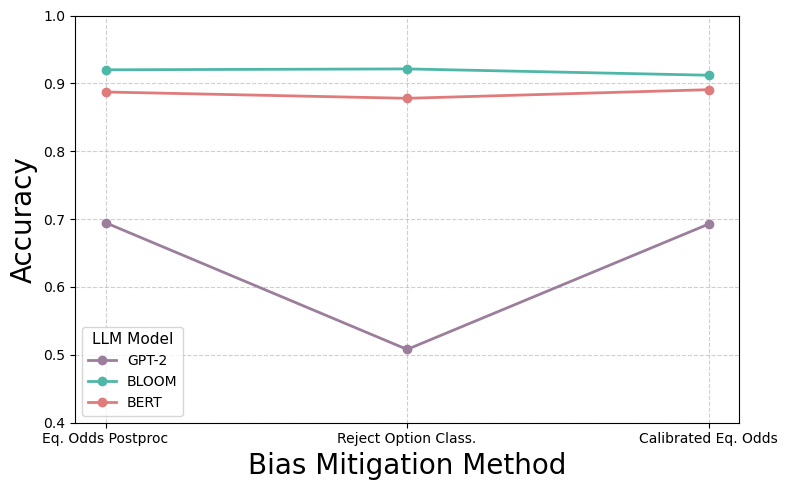

In [30]:
import matplotlib.pyplot as plt

# Data
models = ["GPT-2", "BLOOM", "BERT"]
methods = ["Eq. Odds Postproc", "Reject Option Class.", "Calibrated Eq. Odds"]
accuracies = {
    "GPT-2": [0.6947, 0.5080, 0.6927],
    "BLOOM": [0.9200, 0.9213, 0.9120],
    "BERT": [0.8873, 0.8780, 0.8907]
}

# Custom colors
colors = {
    "GPT-2": "#9B7E9B",  # Lavender
    "BLOOM": "#4FB7A8",  # Teal
    "BERT": "#E07B7B"    # Rose
}

# Plot
plt.figure(figsize=(8, 5))
for model in models:
    plt.plot(methods, accuracies[model], marker='o', color=colors[model], label=model, linewidth=2)

# Title and labels
plt.xlabel("Bias Mitigation Method", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.ylim(0.4, 1.0)

# Grid, legend, and style
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="LLM Model", fontsize=10, title_fontsize=11)
plt.tight_layout()

plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_8176\137122326.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=20, fontsize=20)


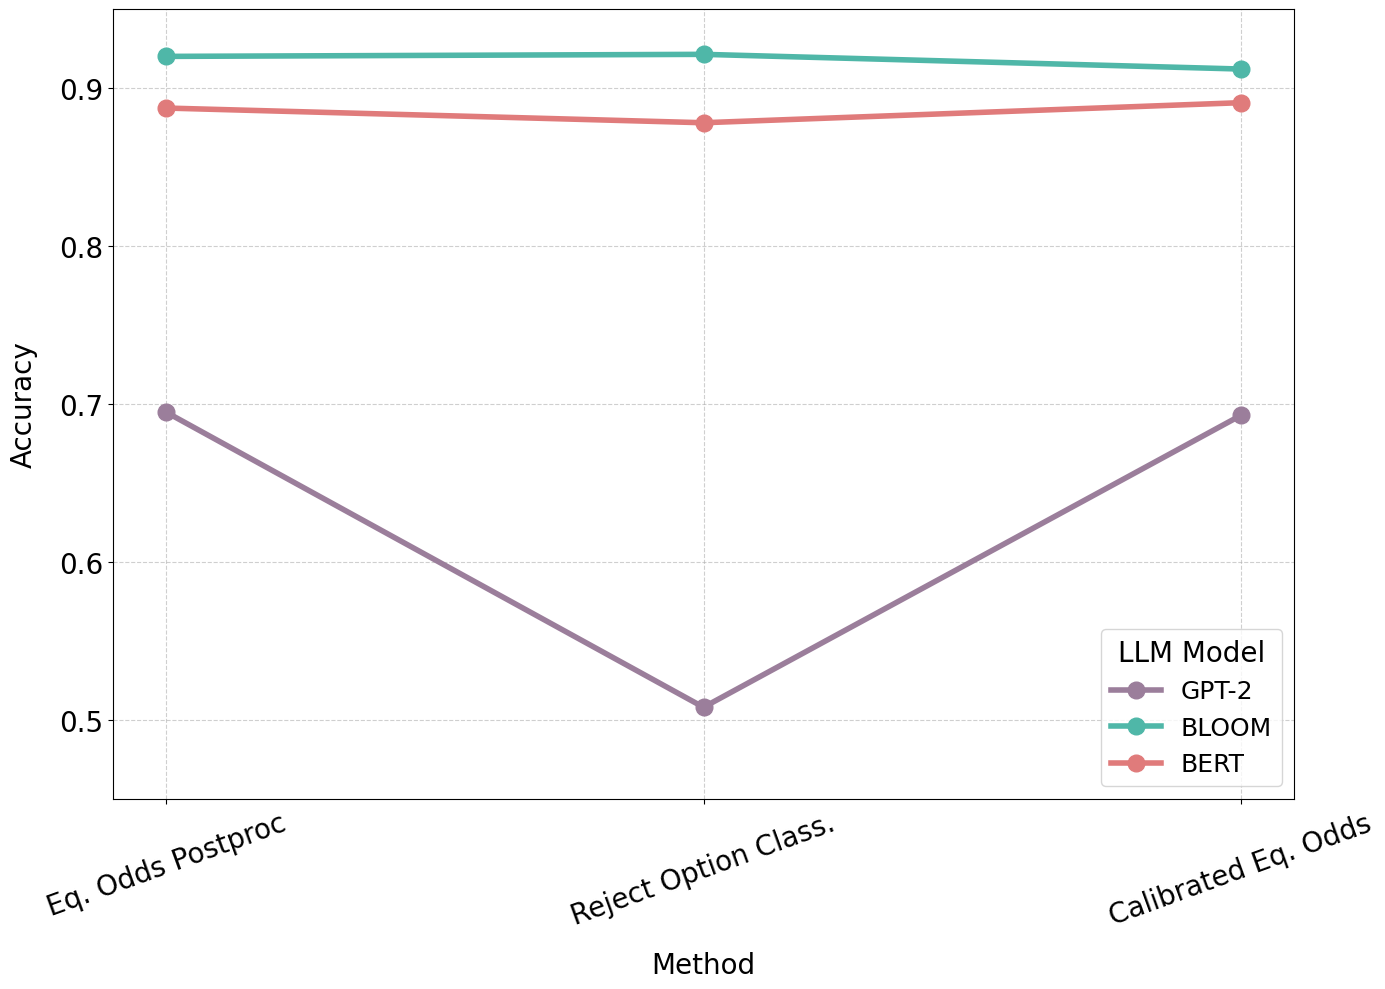

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

# ================================
# Data
# ================================
models = ["GPT-2", "BLOOM", "BERT"]
methods = ["Eq. Odds Postproc", "Reject Option Class.", "Calibrated Eq. Odds"]
accuracies = {
    "GPT-2": [0.6947, 0.5080, 0.6927],
    "BLOOM": [0.9200, 0.9213, 0.9120],
    "BERT": [0.8873, 0.8780, 0.8907]
}

# ================================
# Custom colors
# ================================
colors = {
    "GPT-2": "#9B7E9B",  # Lavender
    "BLOOM": "#4FB7A8",  # Teal
    "BERT": "#E07B7B"    # Rose
}

# ================================
# Plot
# ================================
fig, ax = plt.subplots(figsize=(14, 10))

for model in models:
    ax.plot(methods, accuracies[model],
            marker='o', linewidth=4, markersize=12,
            color=colors[model], label=model)

# ================================
# Labels & Styling
# ================================
ax.set_xlabel("Method", fontsize=20, labelpad=15)
ax.set_ylabel("Accuracy", fontsize=20, labelpad=15)

# X and Y ticks
ax.set_xticklabels(methods, rotation=20, fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylim(0.45, 0.95) 

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="LLM Model", fontsize=18, title_fontsize=20, loc='lower right')

plt.tight_layout()
plt.show()

plt.savefig("LLM_In_Accuracy.png", dpi=300, bbox_inches='tight')

C:\Users\HP\AppData\Local\Temp\ipykernel_8176\2994819937.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=20, fontsize=20)


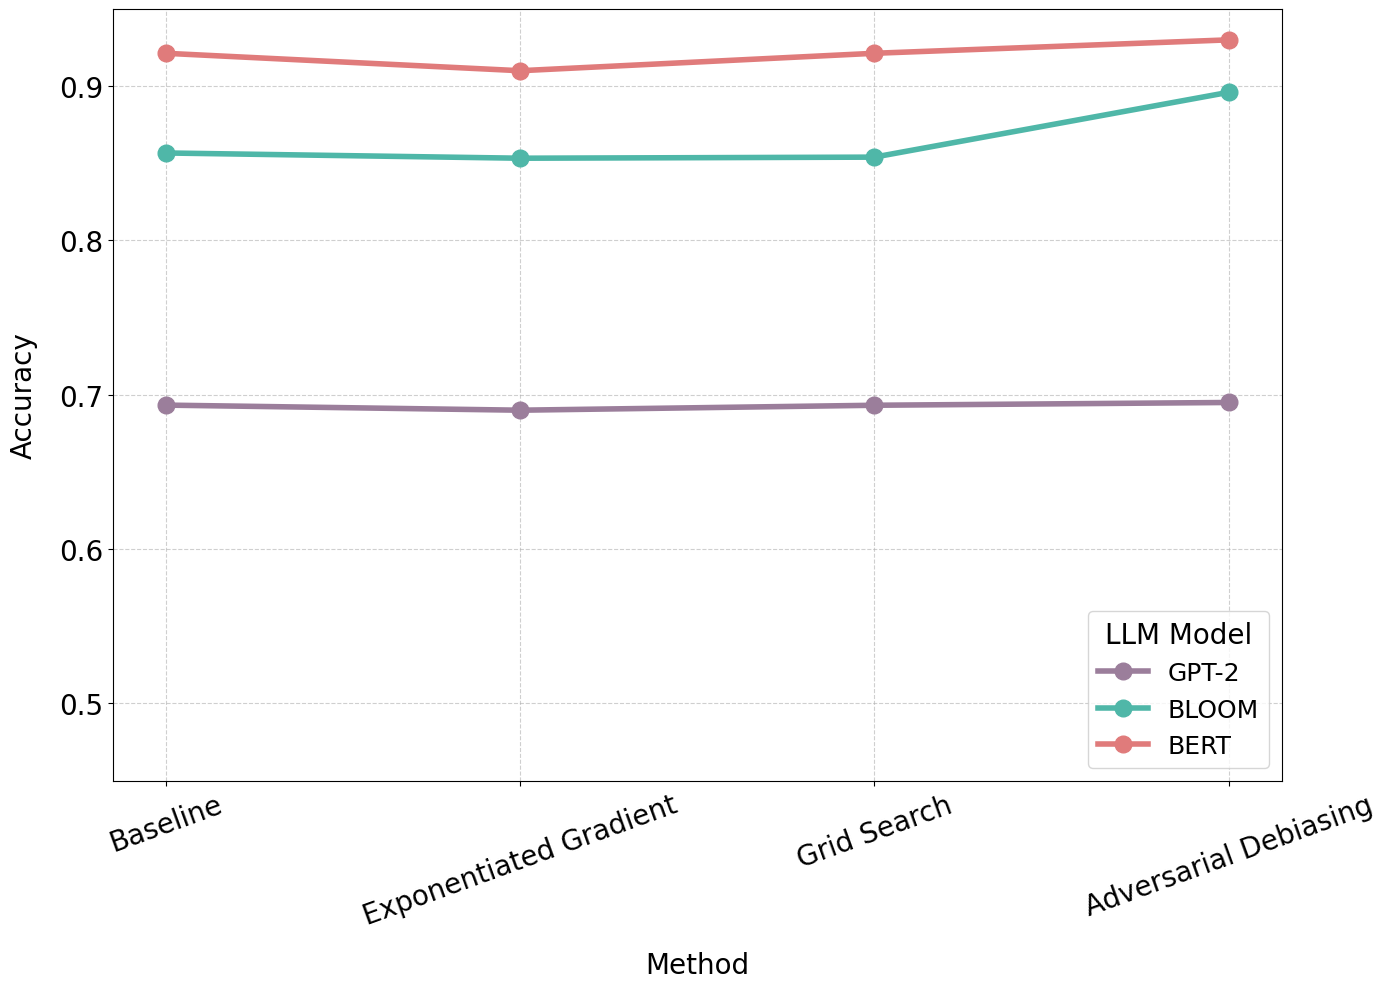

In [26]:
import matplotlib.pyplot as plt

# Data
models = ["GPT-2", "BLOOM", "BERT"]
methods = ["Baseline", "Exponentiated Gradient", "Grid Search", "Adversarial Debiasing"]

accuracies = {
    "GPT-2": [0.6933, 0.690, 0.6932, 0.695],
    "BLOOM": [0.8567, 0.8533, 0.8540, 0.8960],
    "BERT":  [0.9213, 0.9100, 0.9213, 0.9300]
}

# Custom colors
colors = {
    "GPT-2": "#9B7E9B",  # Lavender
    "BLOOM": "#4FB7A8",  # Teal
    "BERT": "#E07B7B"    # Rose
}

# ================================
# Plot
# ================================
fig, ax = plt.subplots(figsize=(14, 10))

for model in models:
    ax.plot(methods, accuracies[model],
            marker='o', linewidth=4, markersize=12,
            color=colors[model], label=model)

# ================================
# Labels & Styling
# ================================
ax.set_xlabel("Method", fontsize=20, labelpad=15)
ax.set_ylabel("Accuracy", fontsize=20, labelpad=15)

# X and Y ticks
ax.set_xticklabels(methods, rotation=20, fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylim(0.45, 0.95) 

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="LLM Model", fontsize=18, title_fontsize=20, loc='lower right')

plt.tight_layout()
plt.show()

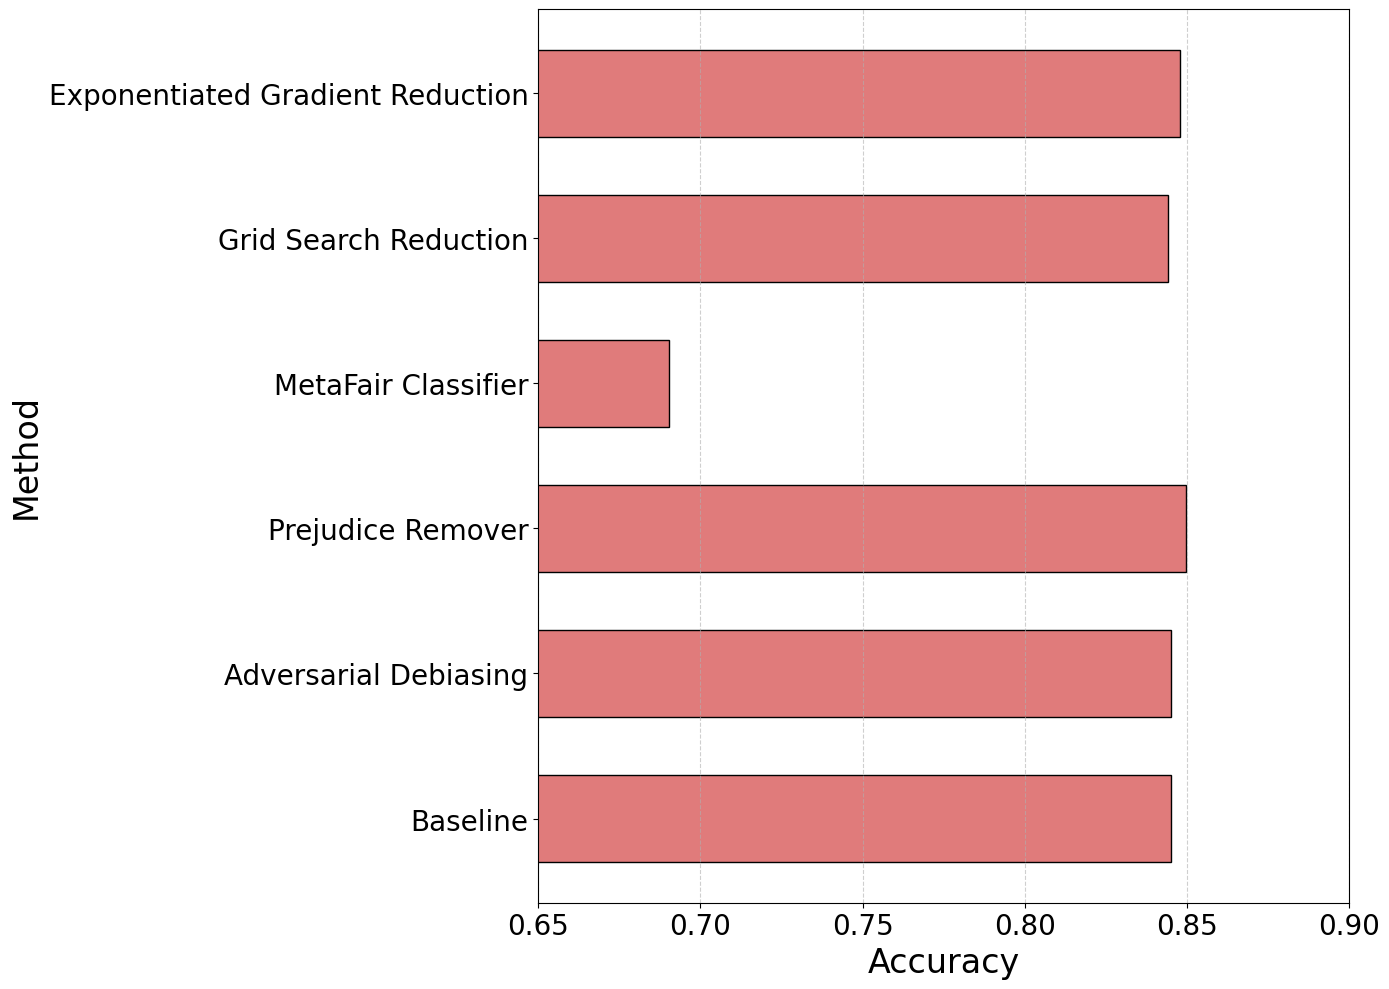

✅ Figure saved as Accuracy_HorizontalBar.png


In [32]:
import matplotlib.pyplot as plt

# ================================
# Data
# ================================
methods = [
    "Baseline",
    "Adversarial Debiasing",
    "Prejudice Remover",
    "MetaFair Classifier",
    "Grid Search Reduction",
    "Exponentiated Gradient Reduction"
]
accuracy = [0.845139, 0.844992, 0.849709, 0.690425, 0.844107, 0.847866]

# ================================
# Plot
# ================================
colors = ["#E07B7B"] * len(methods)

fig, ax = plt.subplots(figsize=(14, 10))
bars = ax.barh(methods, accuracy, color=colors, edgecolor="black", height=0.6)

# Labels & Styling
plt.xlabel("Accuracy", fontsize=24)
plt.ylabel("Method", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.65, 0.9)
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()

# ================================
# Save & Show
# ================================
plt.savefig("Accuracy_HorizontalBar.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figure saved as Accuracy_HorizontalBar.png")

